<a href="https://colab.research.google.com/github/AishwaryaSukumaran/Final-Project_22058088/blob/main/Energy_data_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title: Time Series Analysis and SARIMA Modeling of Household Energy Consumption

**Description:**
In today's world, efficient energy consumption is critical not only for cost reduction but also for environmental sustainability. This project aims to analyze and forecast household energy consumption data to uncover trends, seasonality, and patterns in electricity usage. Using time series analysis techniques, we decompose the data into its trend, seasonal, and residual components. Key consumption insights are derived through combined visualization of weekly, monthly, and yearly averages, with maximum values highlighted. Seasonal trends are analyzed across Winter, Spring, Summer, and Autumn. Finally, a SARIMA model is fitted to the monthly data, providing a 12-month forecast of electricity usage, with performance evaluated through residuals and MSE calculations.

**Objective:**
To analyze and forecast household electricity consumption by:

1. Exploring and visualizing historical energy consumption patterns from 2007 to 2010.

2. Identifying seasonal trends, peaks, and yearly variations.

3. Developing a SARIMA (Seasonal ARIMA) model for forecasting monthly energy usage.

4. Evaluating model performance using residual analysis and error metrics (e.g., MSE).


### 1. Importing Libraries





In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


2. Data Loading and Preprocessing

In [ ]:
# Step 1: Load and preprocess the data
def load_and_preprocess_energy_data(filepath):
    energy_data = pd.read_csv(filepath, sep=';', na_values=['nan', '?'], low_memory=False)
    energy_data['Datetime'] = pd.to_datetime(energy_data['Date'] + ' ' + energy_data['Time'], dayfirst=True)
    energy_data.set_index('Datetime', inplace=True)
    energy_data.drop(['Date', 'Time'], axis=1, inplace=True)
    energy_data['Global_active_power'] = pd.to_numeric(energy_data['Global_active_power'], errors='coerce')
    energy_data.dropna(inplace=True)
    return energy_data

# Path to the dataset
energy_data_filepath = '/content/drive/MyDrive/Final Project/household_power_consumption.txt'
energy_data = load_and_preprocess_energy_data(energy_data_filepath)

# Filter data for the years 2007 to 2010
filtered_energy_data = energy_data[(energy_data.index >= '2007-01-01') & (energy_data.index <= '2010-12-31')]

# Display a random sample of 10 rows from the cleaned dataset
print("\nRandom Sample of the Dataset:")  # Print a label for the output
display(energy_data.sample(10).style.set_table_styles(  # Display the random sample with custom table styles
    [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]  # Styling for table cells
))


Random Sample of the Dataset:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2010-05-08 05:47:00,0.252000,0.000000,245.010000,1.000000,0.000000,0.000000,1.000000
2008-07-04 21:33:00,0.484000,0.000000,239.170000,2.000000,0.000000,0.000000,1.000000
2008-12-26 07:20:00,0.296000,0.050000,243.680000,1.400000,0.000000,0.000000,0.000000
2008-05-28 22:48:00,1.004000,0.260000,241.840000,4.200000,0.000000,0.000000,12.000000
2008-05-18 09:26:00,0.650000,0.110000,236.860000,2.800000,0.000000,0.000000,1.000000
2008-08-06 19:52:00,0.168000,0.142000,241.640000,0.800000,0.000000,1.000000,1.000000
2010-06-29 11:06:00,1.550000,0.000000,236.650000,6.600000,0.000000,0.000000,18.000000
2009-11-28 13:32:00,1.480000,0.112000,242.130000,6.000000,1.000000,0.000000,19.000000
2009-12-31 01:48:00,0.330000,0.104000,241.450000,1.400000,0.000000,0.000000,0.000000


3. Exploratory Data Analysis (EDA)

3.1 Analyze Weekly, Monthly, and Yearly Energy Usage

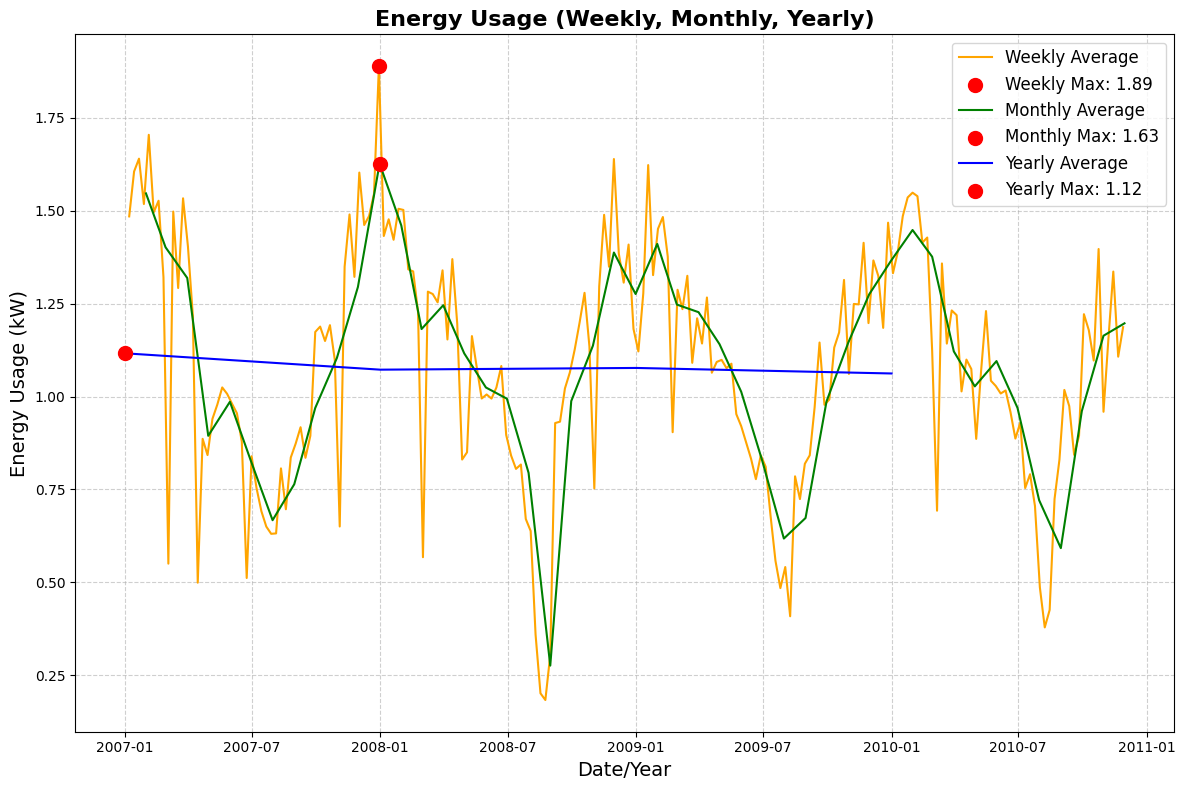

In [ ]:
# Step 2: Combined and Maximum Value Visualization
daily_energy_mean = filtered_energy_data['Global_active_power'].resample('D').mean()
weekly_energy_mean = daily_energy_mean.resample('W').mean()
monthly_energy_mean = daily_energy_mean.resample('ME').mean()
yearly_energy_mean = daily_energy_mean.resample('YE').mean()
yearly_energy_mean.index = yearly_energy_mean.index.year  # Simplify yearly index

def plot_combined_energy_usage(weekly_data, monthly_data, yearly_data):
    plt.figure(figsize=(12, 8))
    max_weekly = weekly_data.max()
    max_weekly_date = weekly_data.idxmax()
    plt.plot(weekly_data.index, weekly_data, color='orange', label='Weekly Average')
    plt.scatter(max_weekly_date, max_weekly, color='red', s=100, zorder=5, label=f"Weekly Max: {max_weekly:.2f}")
    max_monthly = monthly_data.max()
    max_monthly_date = monthly_data.idxmax()
    plt.plot(monthly_data.index, monthly_data, color='green', label='Monthly Average')
    plt.scatter(max_monthly_date, max_monthly, color='red', s=100, zorder=5, label=f"Monthly Max: {max_monthly:.2f}")
    max_yearly = yearly_data.max()
    max_yearly_date = yearly_data.idxmax()
    plt.plot(pd.to_datetime(yearly_data.index, format='%Y'), yearly_data, color='blue', label='Yearly Average')
    plt.scatter(pd.to_datetime(max_yearly_date, format='%Y'), max_yearly, color='red', s=100, zorder=5, label=f"Yearly Max: {max_yearly:.2f}")
    plt.title('Energy Usage (Weekly, Monthly, Yearly)', fontsize=16, fontweight='bold')
    plt.xlabel('Date/Year', fontsize=14)
    plt.ylabel('Energy Usage (kW)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_combined_energy_usage(weekly_energy_mean, monthly_energy_mean, yearly_energy_mean)


3.2 Seasonal Energy Usage Analysis Trends


Random Sample of the Dataset:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Season
Datetime,,,,,,,,
2010-03-30 23:42:00,0.460000,0.234000,240.290000,2.000000,0.000000,1.000000,1.000000,Spring
2010-10-04 22:21:00,0.468000,0.000000,240.010000,2.000000,0.000000,0.000000,0.000000,Autumn
2007-11-26 03:51:00,0.226000,0.000000,245.610000,1.000000,0.000000,0.000000,0.000000,Autumn
2010-06-19 11:58:00,3.744000,0.314000,237.780000,15.800000,37.000000,1.000000,18.000000,Summer
2010-10-21 05:43:00,1.398000,0.048000,245.060000,5.600000,0.000000,0.000000,19.000000,Autumn
2010-06-25 05:01:00,0.154000,0.000000,239.750000,0.600000,0.000000,0.000000,1.000000,Summer
2007-01-09 05:35:00,0.212000,0.000000,240.150000,1.000000,0.000000,0.000000,0.000000,Winter
2010-10-01 16:15:00,1.902000,0.092000,240.250000,7.800000,0.000000,0.000000,19.000000,Autumn
2007-11-14 08:30:00,2.896000,0.090000,240.100000,12.000000,0.000000,1.000000,18.000000,Autumn


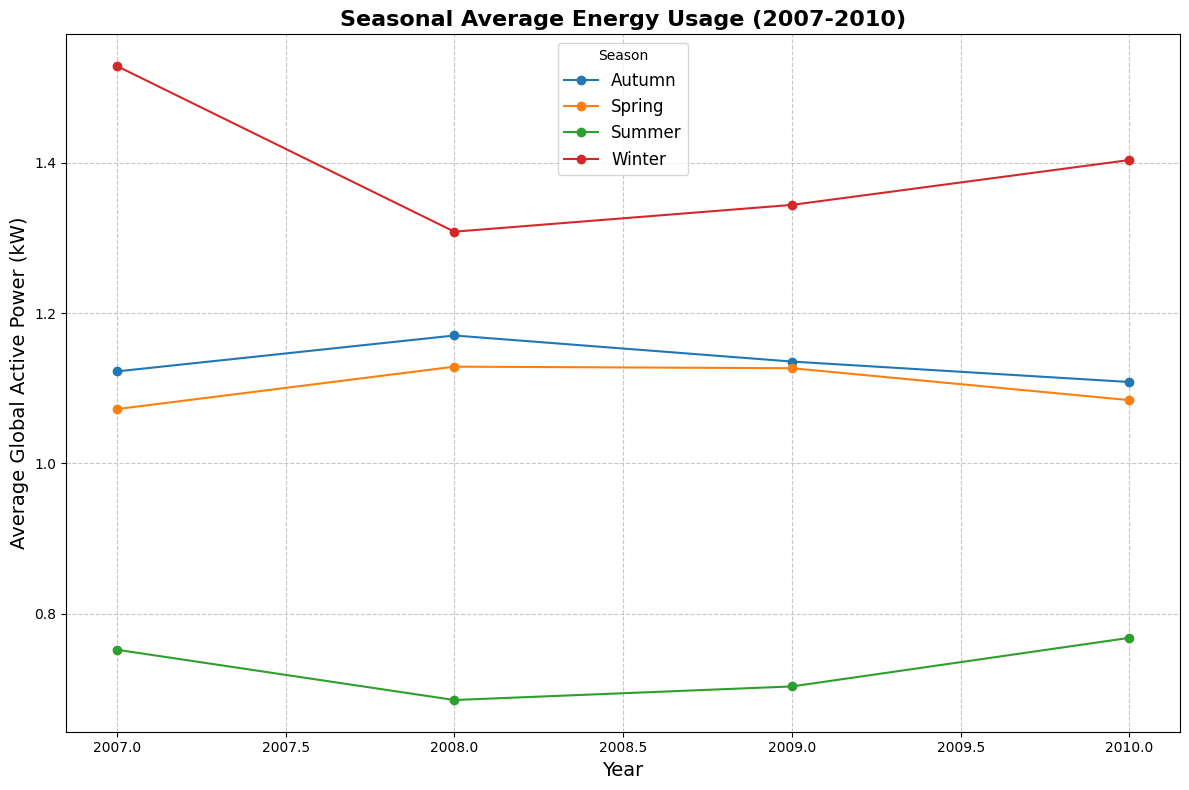

In [ ]:
# Step 3: Seasonal Analysis
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Make a copy of the filtered data
filtered_energy_data = filtered_energy_data.copy()
filtered_energy_data['Season'] = filtered_energy_data.index.map(get_season)

# Display a random sample of 10 rows from the cleaned dataset
print("\nRandom Sample of the Dataset:")  # Print a label for the output
display(filtered_energy_data.sample(10).style.set_table_styles(  # Display the random sample with custom table styles
    [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]  # Styling for table cells
))

# Group data by year and season
seasonal_avg_per_year = filtered_energy_data.groupby([filtered_energy_data.index.year, 'Season'])['Global_active_power'].mean().unstack()

# Plot seasonal averages
plt.figure(figsize=(12, 8))
for season in seasonal_avg_per_year.columns:
    plt.plot(seasonal_avg_per_year.index, seasonal_avg_per_year[season], label=season, marker='o', linestyle='-')
plt.title('Seasonal Average Energy Usage (2007-2010)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Global Active Power (kW)', fontsize=14)
plt.legend(title='Season', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


4. Time Series Decomposition (STL)

Decomposed Time Series Data (STL):


,Actual,Trend,Seasonal,Residual
Month,,,,
2007-01-31 00:00:00,1.546060,1.138762,0.391291,0.016006
2007-02-28 00:00:00,1.401130,1.134883,0.183047,0.083200
2007-03-31 00:00:00,1.318649,1.131173,0.198170,-0.010694
2007-04-30 00:00:00,0.894376,1.127556,-0.140623,-0.092557
2007-05-31 00:00:00,0.985862,1.123948,-0.130283,-0.007803
2007-06-30 00:00:00,0.826748,1.120326,-0.243630,-0.049948
2007-07-31 00:00:00,0.667468,1.116710,-0.403423,-0.045819
2007-08-31 00:00:00,0.764187,1.113206,-0.508337,0.159318
2007-09-30 00:00:00,0.969332,1.110048,-0.123097,-0.017619


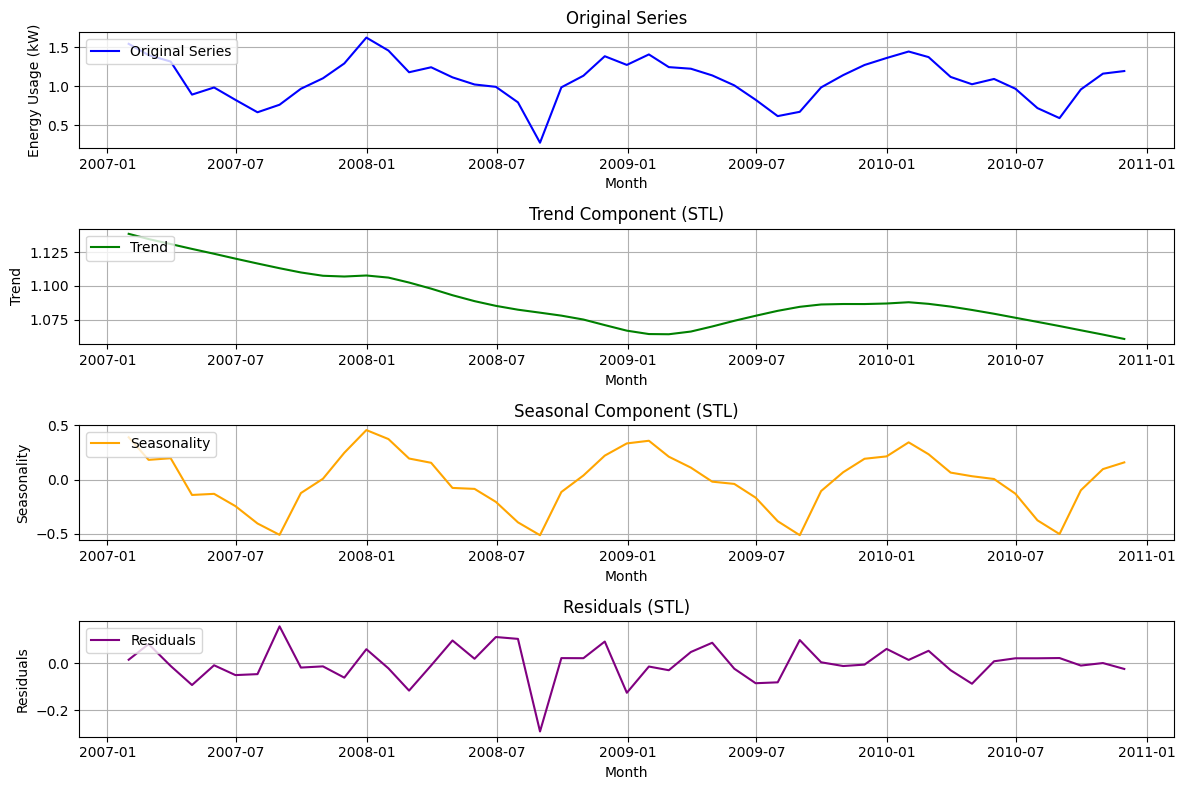

In [ ]:

# Step 4: Decompose the time series using STL
stl = STL(monthly_energy_mean, seasonal=13)  # Decompose with a yearly seasonality
stl_result = stl.fit()

# Extract components
trend = stl_result.trend
seasonal = stl_result.seasonal
residual = stl_result.resid

# Create a DataFrame to display decomposition results
decomposed_data_stl = pd.DataFrame({
    'Month': monthly_energy_mean.index,
    'Actual': monthly_energy_mean.values,
    'Trend': trend.values,
    'Seasonal': seasonal.values,
    'Residual': residual.values
})

# Set 'Month' as the index for better presentation
decomposed_data_stl.set_index('Month', inplace=True)

# Display the first few rows of the decomposed data
print("Decomposed Time Series Data (STL):")
display(decomposed_data_stl.style.set_table_styles(  # Display the random sample with custom table styles
    [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]  # Styling for table cells
))

# Plot the decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(monthly_energy_mean, label='Original Series', color='blue')
plt.title('Original Series')
plt.xlabel('Month')
plt.ylabel('Energy Usage (kW)')
plt.legend(loc='upper left')
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='green')
plt.title('Trend Component (STL)')
plt.xlabel('Month')
plt.ylabel('Trend')
plt.legend(loc='upper left')
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality', color='orange')
plt.title('Seasonal Component (STL)')
plt.xlabel('Month')
plt.ylabel('Seasonality')
plt.legend(loc='upper left')
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals', color='purple')
plt.title('Residuals (STL)')
plt.xlabel('Month')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


5. SARIMA Modeling and Forecasting

Simplified SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                   47
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   0.869
Date:                            Thu, 05 Dec 2024   AIC                              0.261
Time:                                    14:24:43   BIC                              1.758
Sample:                                01-31-2007   HQIC                             0.765
                                     - 11-30-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0555      0.011      4.970      0.000       0.034       0.077
Lj

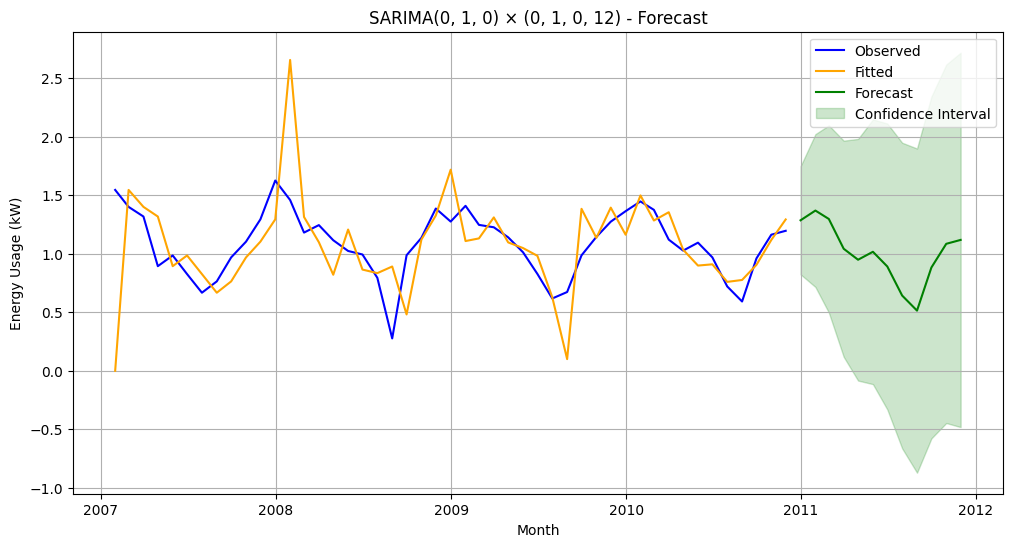

In [ ]:


# Step 5: Fit a SARIMA model


warnings.filterwarnings("ignore")

simpler_model = SARIMAX(
    monthly_energy_mean,
    order=(0, 1, 0),
    seasonal_order=(0, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()


print("Simplified SARIMA Model Summary:")
print(simpler_model.summary())

# Step 6: Forecast the next 12 months
forecast_steps = 12
forecast = simpler_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(monthly_energy_mean, label='Observed', color='blue')
plt.plot(simpler_model.fittedvalues, label='Fitted', color='orange')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title('SARIMA(0, 1, 0) × (0, 1, 0, 12) - Forecast')
plt.xlabel('Month')
plt.ylabel('Energy Usage (kW)')
plt.legend()
plt.grid()
plt.show()


6. Residual Analysis and Performance Evaluation

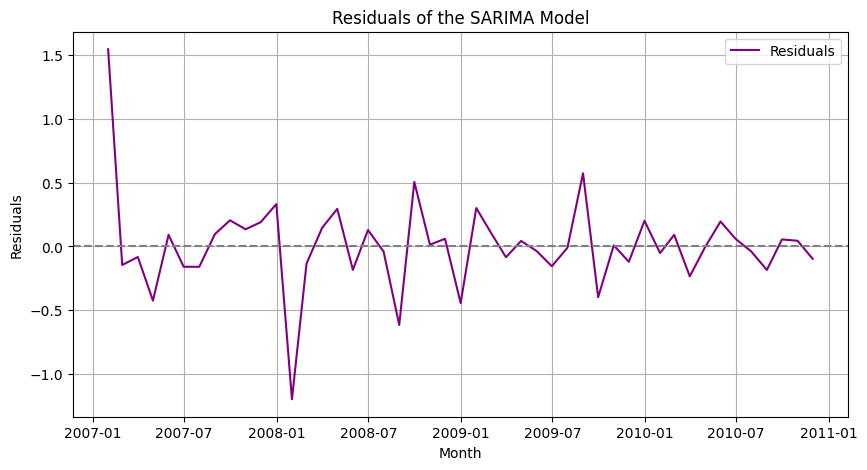

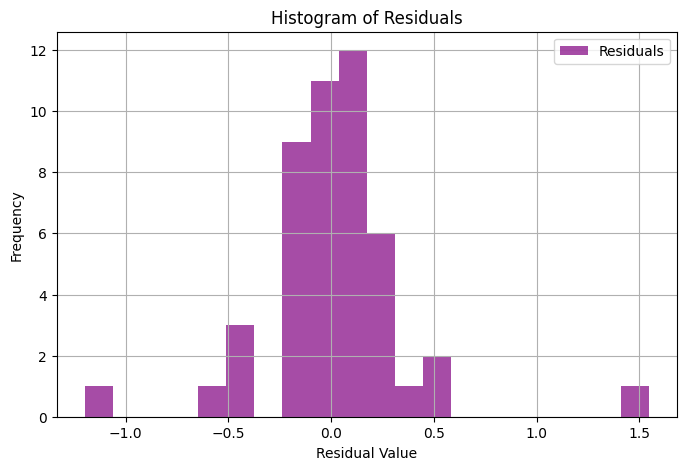

Training Mean Squared Error (MSE): 0.1310


In [ ]:
# Step 7: Evaluate residuals
residuals = simpler_model.resid

plt.figure(figsize=(10, 5))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals of the SARIMA Model')
plt.xlabel('Month')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, color='purple', alpha=0.7, label='Residuals')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Step 8: Evaluate model performance
train_mse = mean_squared_error(monthly_energy_mean, simpler_model.fittedvalues)
print(f"Training Mean Squared Error (MSE): {train_mse:.4f}")


7. Autocorrelation Analysis

<Figure size 1200x600 with 0 Axes>

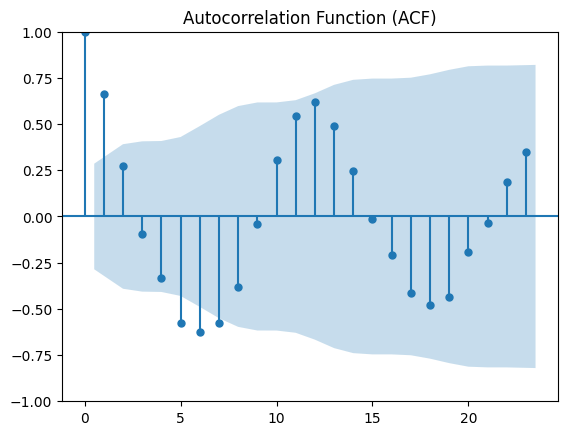

<Figure size 1200x600 with 0 Axes>

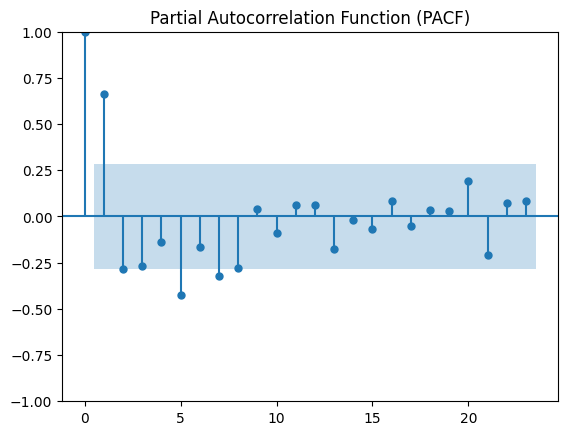

In [ ]:
# Step 8: Autocorrelation Analysis
# Determine the maximum number of lags based on the data size
max_lags = len(monthly_energy_mean) // 2  # Maximum lags allowed for PACF

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(monthly_energy_mean, lags=max_lags, title='Autocorrelation Function (ACF)')
plt.show()

# Plot PACF with adjusted lags
plt.figure(figsize=(12, 6))
plot_pacf(monthly_energy_mean, lags=max_lags, title='Partial Autocorrelation Function (PACF)')
plt.show()
